# Stackexchange Health Posts Data Analysis
## Overview of the StackExchange dataset
<p>StackExchange provides a variety of datasets featuring social media posts. Typically, datasets can either feature end-user posts, 
or posts <i>about</i> the site and the posts themselves, presumably by content authors and moderators. The latter include word <i>meta</i>
in their name.</p>
<p>The chosen dataset for this project is the 'health.stackexchange.com' dataset, containing end-user posts on the subject of health.  
<br/>This dataset contains the following XML files: <ul>
    <li>Posts.xml: the core data, with Title, Body, CreationDate, ViewCount, Tags, etc. </li>
    <li>Comments.xml: comments provided by other users on the posts. </li>
    <li>PostHistory.xml: data relative to the editorial changes posts have undergone </li>
    <li>PostLinks.xml: relations between posts</li>
    <li>Tags.xml: topic tags attached to the posts. This data is included in Posts.xml </li>
    <li>Users.xml: users that contribute to the site, with profiles</li>
    <li>Votes.xml: approval votes for posts</li>
    <li>Badges.xml: contributing users' roles</li></ul>
</p>
<p>This project's focus is a comparison of natural language search frameworks, so the only XML file of interest is Posts.xml. The other files can be overlooked.</p>

## Extract Raw Data
<p>StackExchange datasets are distributed in XML format. Each record in Posts.xml is tagged as a "row" with attributes, representing the record's fields. 
Rows do not include a consistently complete set of attributes, as we will see.</p>
<p>From a search point of view, the text of the posts is contained in the "Title" and "Body" attributes. The "Tags" attribute features a classification of 
the posts' content by health topic. The "ViewCount" attribute is also interesting as it ranks the posts by popularity.</p>
<p>The "Body" attribute is HTML. So, the first step is to extract the text by removing the HTML tags.</p>

In [1]:
import pandas as pd
import os
import xml.etree.ElementTree as ET
import numpy as np
from health_exchange.data import extract_raw_data

data_dir = '../data'
health_data_path = os.path.join(os.path.abspath(data_dir), "health.stackexchange.com")
posts_file = os.path.join(health_data_path, "Posts.xml")
posts_fields = ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'Body', 
                'LastEditDate', 'LastActivityDate', 'Title',
                'Tags', 'AnswerCount', 'CommentCount', 'ContentLicense']

posts_df = extract_raw_data(posts_file, posts_fields)
print(f"Extracted {len(posts_df)} raw posts from {os.path.basename(posts_file)}")

[01/26/23 16:12:56] INFO     Extracted 14601 data rows from /home/fbeghell/Pycharm ]8;id=103287;file:///home/fbeghell/PycharmProjects/HealthSearch/health_exchange/data.py\data.py]8;;\:]8;id=86903;file:///home/fbeghell/PycharmProjects/HealthSearch/health_exchange/data.py#45\45]8;;\
                             Projects/Health_Search/data/health.stackexchange.com/           
                             Posts.xml                                                       

Extracted 14601 raw posts from Posts.xml


In [2]:
posts_df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,ContentLicense
0,2,1,2015-03-31T19:00:01.793,43,51152,<p>The following tooth cracks are noticeable w...,2015-03-31T19:33:14.567,2019-12-22T04:22:54.330,What are these lines in teeth?,<dentistry>,1,1,CC BY-SA 3.0
1,3,1,2015-03-31T19:06:32.503,14,351,"<p>(By 'fortified', I refer to this definition...",2017-04-13T12:48:15.073,2015-04-01T00:01:10.120,"Calcium supplements versus ""fortified with cal...",<nutrition>,1,0,CC BY-SA 3.0
2,4,1,2015-03-31T19:11:24.947,32,1011,<p>One of the most often-cited facts about hum...,None,2017-01-16T14:14:31.053,If human life is so long largely due to modern...,<life-expectancy><disease><statistics>,2,3,CC BY-SA 3.0
3,5,1,2015-03-31T19:21:14.007,15,329,"<p>Every time one takes a pill, drinks a glass...",2015-04-08T18:37:28.483,2016-06-11T10:40:39.660,Can the immune system break down anything?,<immune-system><drug-metabolism>,4,2,CC BY-SA 3.0
4,6,1,2015-03-31T19:26:15.727,26,6478,<p>While playing indoor soccer a couple days a...,2015-04-13T04:27:47.377,2015-04-15T18:13:37.963,What should I consider when deciding to remove...,<wound><removal>,4,0,CC BY-SA 3.0


<p>As we can see above, Posts.xml contains 14601 posts with their data. It's convenient to write the DataFrame to a csv file, for persistence. </p>

In [3]:
# Store dataframe as csv file  
import csv
posts_csv_file = os.path.join(data_dir, "posts.csv")
posts_df.to_csv(posts_csv_file, encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

## Data Validation with great_expectations
To check the validity of the data, we use package 'great_expectations'. For search, the columns that are relevant include the following:
<ul><li>Title</li>
    <li>Body</li>
    <li>Tags</li>
    <li>ViewCount</li></ul>
<p>Data validation with great_expectations will focus on these. 

<p>With <b>great_expectations</b>, we can run individual validation tests as shown below. However, great_expectations allows for the interactive 
creation of a <i>suite</i> of expectations, i.e., validation tests: these that can be manually created with the help of an auto-generated notebook. </p>
<p>Once the suite with validation tests is created, it can be run, and based on the results, the data can be fixed, the suite modified, and re-run 
till the results are as expected. <p>
<p>Below is an example of a single validation test:</p>

In [4]:
import great_expectations as ge
import json
from urllib.request import urlopen

df = ge.dataset.PandasDataset(posts_df)

# column expectations: Id's should be unique
print(df.expect_column_values_to_be_unique(column="Id"))

{
  "expectation_config": {
    "meta": {},
    "expectation_type": "expect_column_values_to_be_unique",
    "kwargs": {
      "column": "Id",
      "result_format": "BASIC"
    }
  },
  "success": true,
  "meta": {},
  "result": {
    "element_count": 14601,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}


<p>The following include some of the expectation tests that can be run on the dataset:
<ol><li>expect_table_columns_to_match_ordered_list(
            column_list=["Id","PostTypeId","CreationDate","Score","ViewCount","Body",
                         "OwnerUserId","LastEditDate","LastActivityDate","Title",
                         "Tags","AnswerCount","CommentCount","ContentLicense",])</li>
    <li>expect_column_values_to_be_unique(column="Id")</li>
    <li>expect_column_values_to_not_be_null(column="Id")</li>
    <li>expect_column_values_to_not_be_null(column="Title")</li>
    <li>expect_column_values_to_not_be_null(column="Body")</li>
    <li>expect_column_values_to_not_be_null(column="Tags")</li>
    <li>expect_column_values_to_be_of_type(column="Title", type_="str")</li>
    <li>expect_column_values_to_be_of_type(column="Body", type_="str")</li>
    <li>expect_column_values_to_be_of_type(column="Tags", type_="str")</li>
    <li>expect_column_values_to_not_be_null(column="CreationDate")</li>
</ol>
</p>

<p>Once the expectation tests are collected into a suite, a 'checkpoint' can be defined for the suite and datasource. Checkpoints can be re-run anytime, as the data changes, 
to check for the continued validity of the data. <br/>
Running a great_expectations suite and a checkpoint produces the following output:
</p><p>
<img src="../images/great_expectations1.png" alt="suite_out" width="800">
</p><p>
<img src="../images/great_expectations2.png" alt="checkpoint_out" width="800">

### great_expectations Results:
As it turns out, expectations 4, 5, 6 are not borne out, and return a failure status. It turns out that the posts dataset contains a number of rows where either the Title, Body, 
or Tags are missing or empty. </p> 
<p>Overall, running expectation tests on the 'posts.csv' dataset shows the followiing:<ol>
<li>Titles: 6779 (46.43%) are null/empty, but otherwise all titles are unique, and of type str</li>
<li>ViewCount: 6779 (46.43%) are null/empty</li>
<li>Body: all unique, but 167 (1.14%) are null/empty</li>
<li>Tags: 6779 (46.43%) are null/empty</li>
<li>CreationDate: none are null</li></ol>
<p>Given the requirements of our planned application, which is search, we can draw the following conclusions: <ol>
<li>rows with null/empty Body should be removed. The Body column provides most of the searchable material.</li>
<li>null/empty Titles and Tags pose a potential issue, but for these, there are remedial strategies: i.e., these may be reconstructed in some way</li>
<li>the fact that the number of null Title, ViewCount, and Tags match, may indicate that a batch of data with missing values was added to the dataset at some point.</li></ol>
</p>

## Data Visualizations with Pandas and matplotlib.pyplot
<p>Continuing with data analysis, we can gain a better understanding of the data and how to use it in our intended application, by 
running a number of visualizations.</p>

### Creation dates of Posts, by year
<p>The bar graph below reflects Posts' CreationDate, grouped by year. It gives an idea about the vitality of the site. Overall, we see a decline over the last 2 years. 
This information, interesting as it is, has however no direct bearing on the project at hand.</p>

<AxesSubplot:xlabel='CreationDate'>

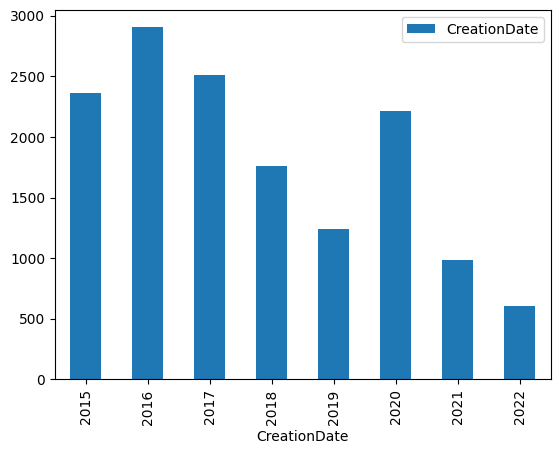

In [5]:
creation_date_df = posts_df[['CreationDate']].copy()
creation_date_df['CreationDate'] = creation_date_df["CreationDate"].astype("datetime64")
creation_date_df.groupby(creation_date_df["CreationDate"].dt.year).count().plot(kind="bar")

### Content Creation: Top 50 most frequent Tags
<p>Posts are tagged by health topics. Each post may receive multiple topic tags. Here we display the frequency of individual tags. This provides an overview of the most popular topics, from the point of view of content creation.</p>
<p>Predictably, Covid and related, figure prominently among the most popular topics. Other more traditional topics include nutrition, cancer, mental health, etc. </p>
<p>Note: the tag frequencies are also available directly from file "Tags.xml". We have extracted them by counting from "Posts.xml", for verification.</p>

                     Tag  Count
0               covid-19    655
1              nutrition    515
2            medications    404
3            vaccination    285
4                   diet    271
5            dermatology    247
6                  virus    219
7          immune-system    199
8              dentistry    194
9                 cancer    192
10                 sleep    190
11             infection    170
12          side-effects    166
13           terminology    156
14                 blood    149
15                   eye    145
16              research    128
17                 brain    127
18              exercise    126
19             neurology    125
20           blood-tests    124
21           coronavirus    124
22                  pain    123
23         mental-health    119
24  disease-transmission    118
25          epidemiology    118
26            statistics    115
27             treatment    115
28             digestion    114
29               surgery    108


<AxesSubplot:title={'center':'Top 50 Most Frequent Tags'}, xlabel='Tag'>

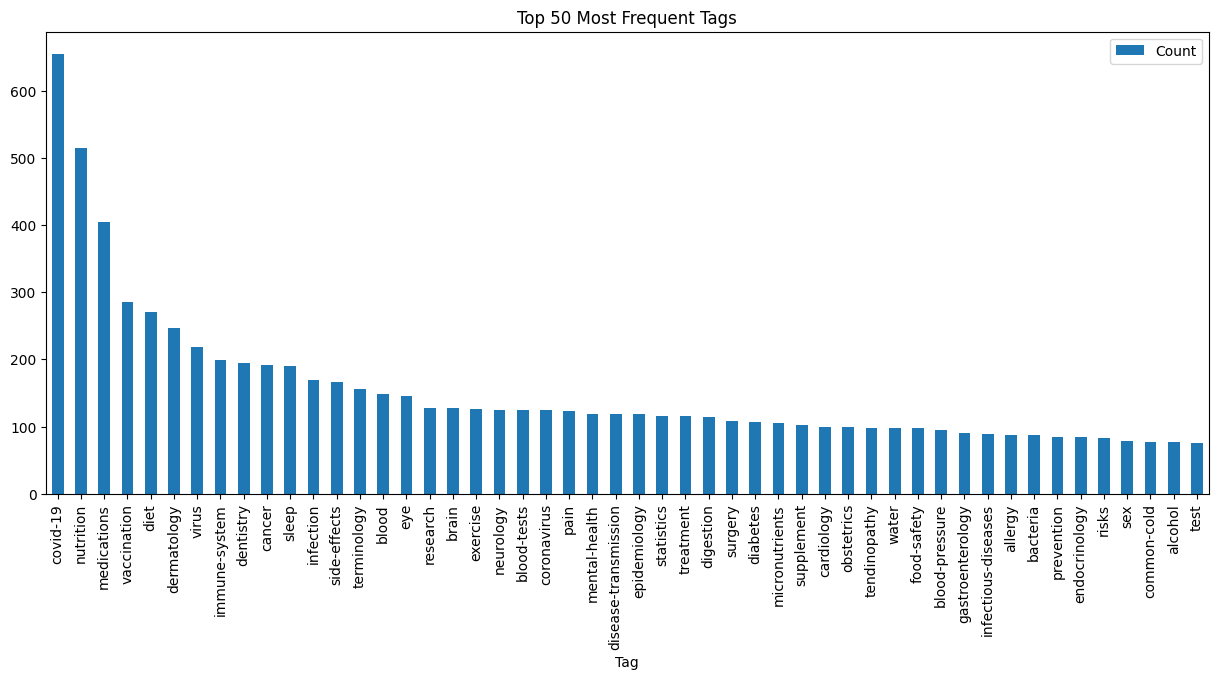

In [6]:
import numpy as np
from collections import Counter
import itertools
import matplotlib.pyplot as plt

tags_raw = posts_df[['Tags']].copy().values.tolist() 
tags = []
for raw in tags_raw:
    if raw[0] is None:
        continue
    temp = raw[0][1:-1]
    ts = temp.split("><")
    tags.extend(ts)
tag_counts = Counter(tags).most_common(50)
tags_df = pd.DataFrame.from_records(list(dict(tag_counts).items()), columns=['Tag', 'Count'])
print(tags_df.head(30))
tags_df.plot(x='Tag', y='Count', kind='bar', figsize=(15, 6), title='Top 50 Most Frequent Tags')

### Content Consumption: Top 30 Most Viewed Posts
<p>We look now at the frequency of Posts' views. What are the most viewed Posts, both individually, and grouped by tags? </p>
<p>Turns out that these two frequencies are similar. This indicates that ViewCount is driven more by individual posts, than by their topics. </p>
<p>Note also that topic frequency in content creation differs considerably from topic frequency in content consumption. For example, Covid related posts are not among the top 30 topics by view. This may be partly due to Covid being split into several tags. But generally this discrepancy is something that the site content administrators might want to look at</p>. 

In [7]:
tags_by_view_df = posts_df[['Tags', 'ViewCount', 'Title']].copy()
tags_by_view_df = tags_by_view_df.dropna()
tags_by_view_df['ViewCount'] = tags_by_view_df['ViewCount'].astype(int)
sorted_tags_by_view = tags_by_view_df.sort_values(by=['ViewCount'], ascending=False)
sorted_tags_by_view = sorted_tags_by_view[:10]
pd.options.display.max_colwidth = 80
print(f"Top 30 Individual Posts by ViewCount")
sorted_tags_by_view.head(30)
# ax = sorted_tags_by_view.plot(x='Tags', y='ViewCount', kind='barh', figsize=(10, 10), title='Top 30 Tags by ViewCount')
# ax.invert_yaxis()

Top 30 Individual Posts by ViewCount


,Tags,ViewCount,Title
689,<cardiology>,397631,Is it normal to feel your heart beat in your chest?
4061,<nutrition><food-poisoning>,237282,Is it dangerous to eat bananas and eggs together?
1747,<eye>,230238,What does eye power -6 means and how close to blindness is it?
4626,<penis><masturbation><saliva><circumcision><lubrication>,188055,Is saliva safe as a sexual lubricant for male masturbation?
3014,<nutrition><terminology><calories>,150709,What is the difference between cal and Kcal?
3096,<weight-loss><body-fat><body-weight>,126608,"How many Calories Deficit Equals 1 KG Loss, approximately"
2524,<medications><digestion><stomach>,115119,How much food is necessary to buffer the stomach when taking medicine?
2174,<optometry><iris>,100793,What is this dot on the iris?
2855,<sleep><spine><position>,91921,Is it better to sleep without a pillow?
1016,<removal><urinary-system><penis><death>,85784,Do you bleed to death after your penis is cut off?


                                                                              ViewCount
Tags                                                                                   
<cardiology>                                                                     398607
<eye>                                                                            241407
<nutrition><food-poisoning>                                                      237282
<penis><masturbation><saliva><circumcision><lubrication>                         188055
<nutrition><terminology><calories>                                               150709
<weight-loss><body-fat><body-weight>                                             126700
<medications><digestion><stomach>                                                120319
<medications>                                                                    109563
<optometry><iris>                                                                100793
<sleep><spine><position>        

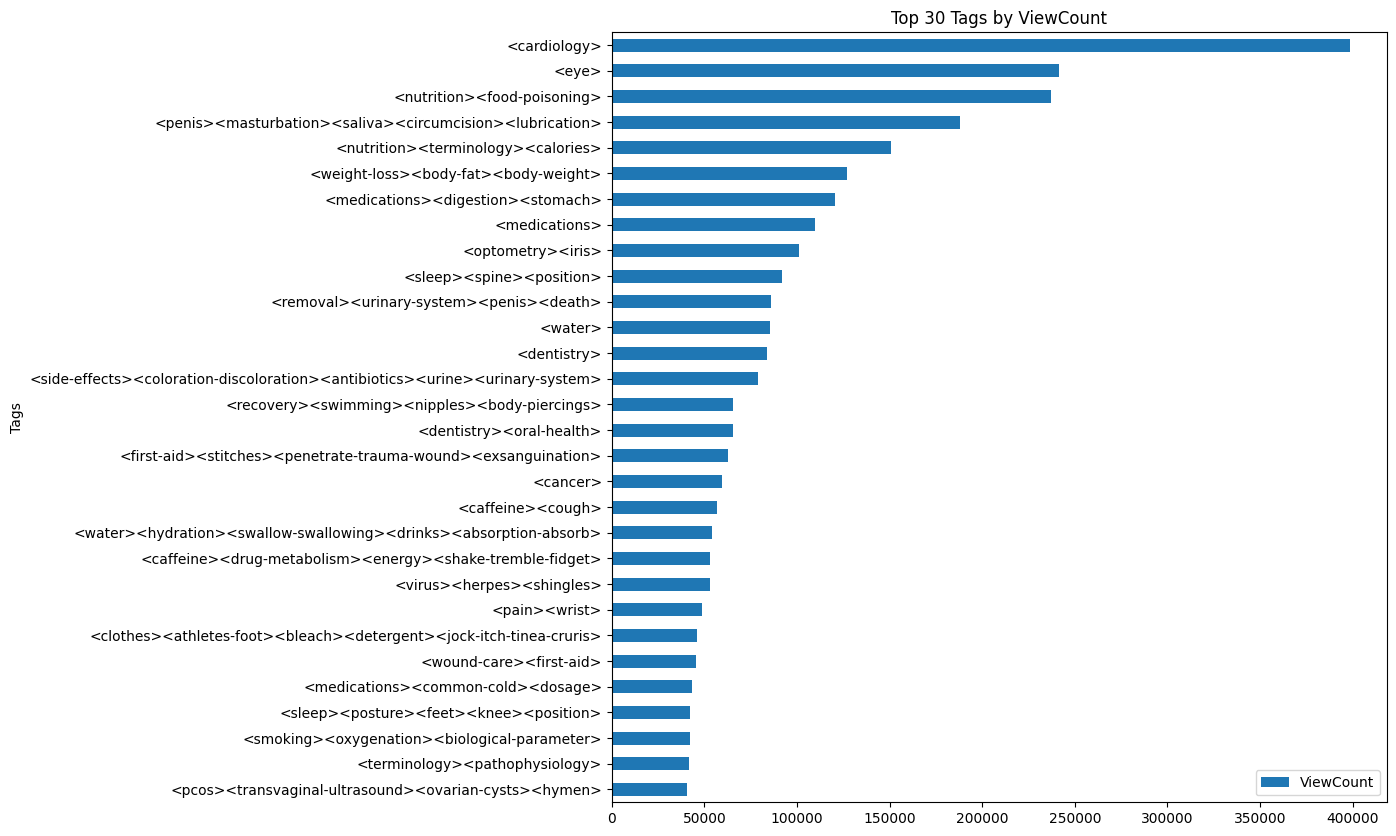

In [8]:
tags_by_view_df = posts_df[['Tags', 'ViewCount']].copy()
tags_by_view_df.replace(to_replace=['None'], value=np.nan, inplace=True)
tags_by_view_df = tags_by_view_df.dropna()
tags_by_view_df['ViewCount'] = tags_by_view_df['ViewCount'].astype(int)
sorted_tags_by_view = tags_by_view_df.groupby(['Tags']).sum().sort_values(by=['ViewCount'], ascending=False)
sorted_tags_by_view = sorted_tags_by_view[:30]
print(sorted_tags_by_view.head(15))
ax = sorted_tags_by_view.plot(kind='barh', figsize=(10,10), title='Top 30 Tags by ViewCount')
ax.invert_yaxis()

### Posts text length
<p>The text of the posts comprises the "Title" and "Body" fields. The number of words in the "Body" field most often exceeds 100 words, whereas the "Title" fields are 
very short (5-10 words mostly). </p>
<p>The focus of this project is a comparison of search frameworks, 'Elasticsearch' vs. Semantic search with deep-learning models such as Transformers. While Elasticsearch
can handle document with almost any length of text, Transformers models are more limited in this respect; 512 word/sub-word tokens is usually the limit. As will be discussed 
in the Models notebook, Transformers models output vector representations for each word (or sub-word) in the text. To provide a single vector representation for the whole
text, the (sub)word vectors are typically averaged. Therefore, we can expect the averaged vector for a long text to be somewhat diluted. In fact, Transformer-based models 
achieve better linguistic accuracy when the length of the text/document is the size of a short paragraph.</p>
<p>On the other hand, it is helpful for a search application to point the end-user to a specific paragraph in the document, rather than the whole document, especially when
this is quite long. We can refer to these paragraph-sized retrievals as document 'snippets'</p>
<p>For these reasons, we want to break up posts into linguistically well formed snippets, to be served as the primary search results, while keeping track of the position 
and document of the snippets, so that the search UI may provide a user-friendly display of search results as a combination of title, snippet, and a link to the entire 
document. To have an even playing field between Elasticsearch and Transformers, we will use short paragraph snippets as the documents to feed to the search for 
both frameworks. Later on in this project, we will consider augmenting the Body snippets with either titles or tags for added context. </p>
<p>Below is a diagram that shows the length of the Body fields for all the posts in our dataset:</p>

Body word lenghts: mean = 170.54, median = 114.0, max = 3449
Title word lenghts: mean = 5.252, median = 4.0, max = 33


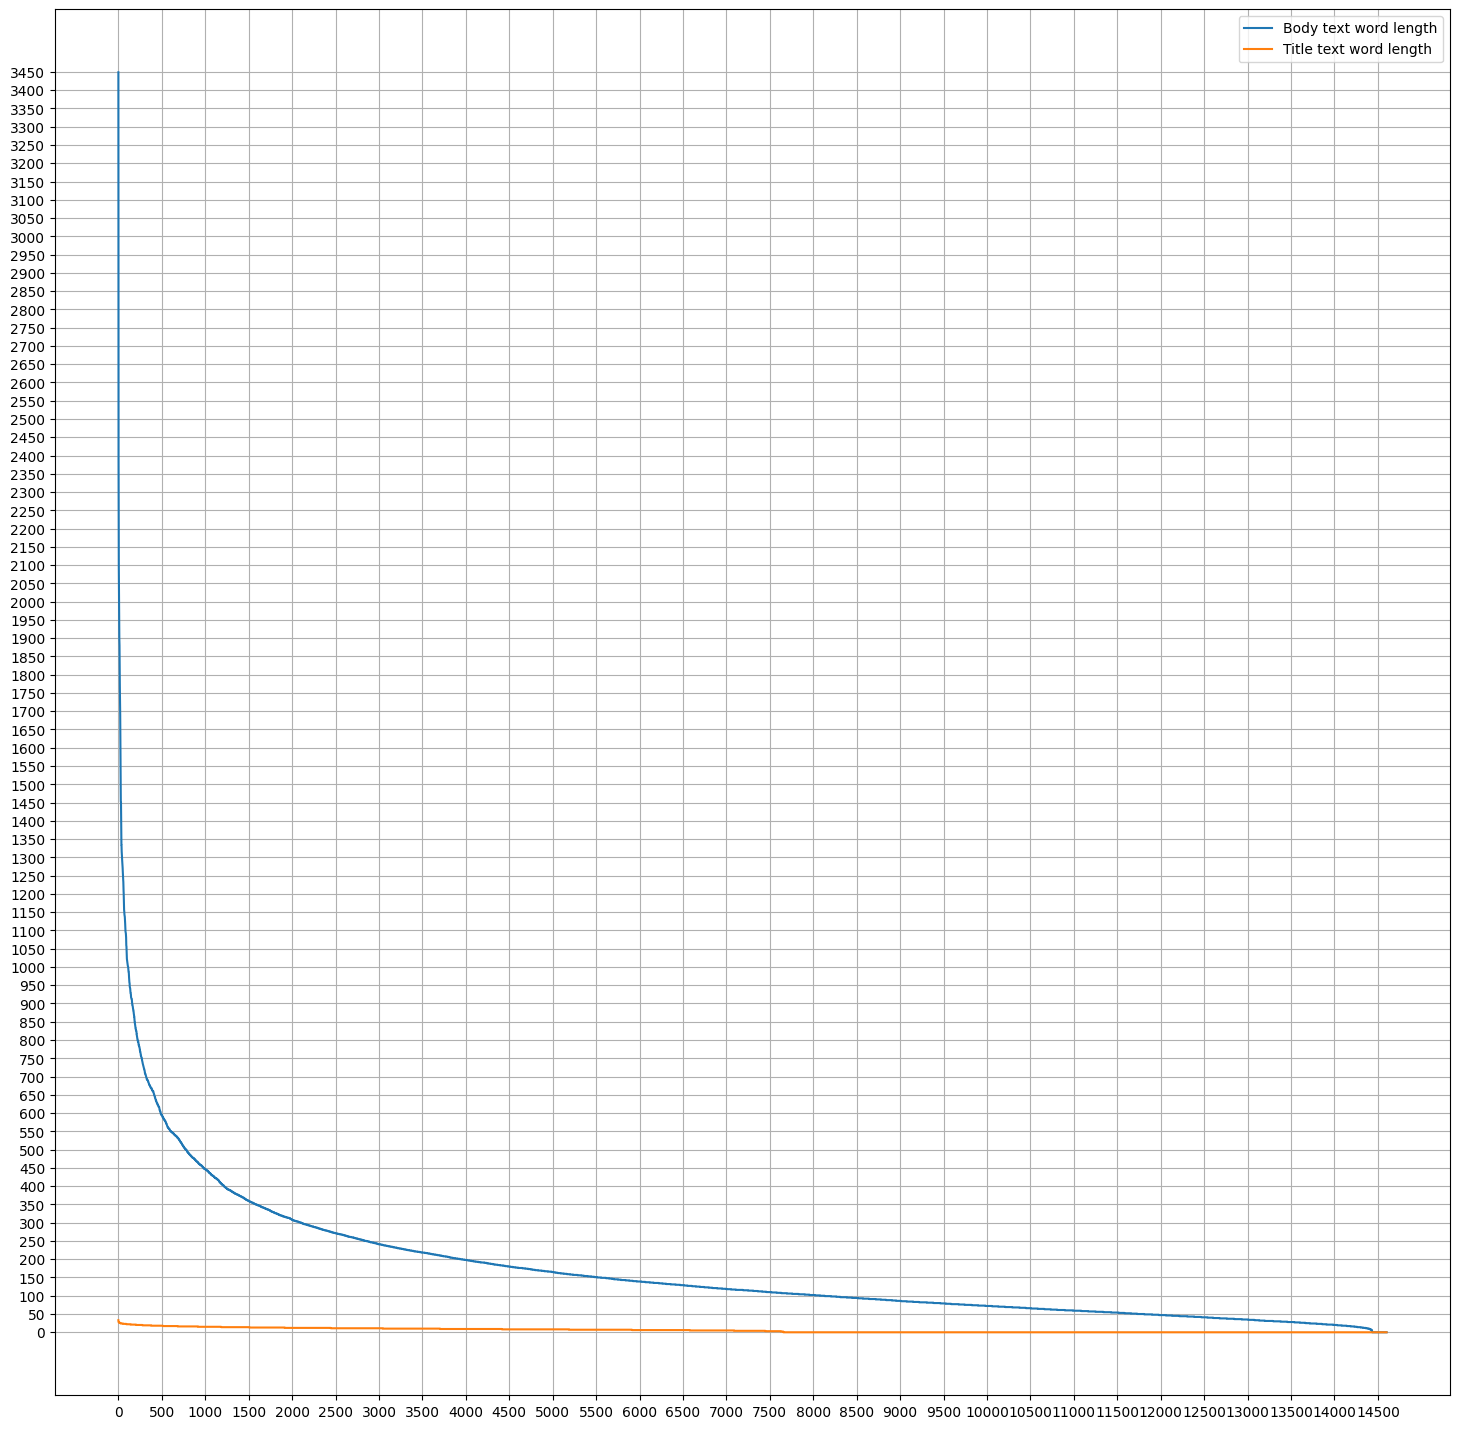

In [9]:
from io import StringIO
from html.parser import HTMLParser
import re
from health_exchange.utils.text_extract import get_word_len, clean_html

clean_text_df = posts_df[['Id', 'Body', 'Title', 'Tags']].copy()
clean_text_df['Body'] = clean_text_df['Body'].apply(clean_html)
body_lengths = [get_word_len(txt) for txt in clean_text_df['Body']]
title_lengths = [get_word_len(txt) for txt in clean_text_df['Title']]
print(f"Body word lenghts: mean = {round(np.mean(body_lengths), 3)}, median = {np.median(body_lengths)}, max = {max(body_lengths)}")
print(f"Title word lenghts: mean = {round(np.mean(title_lengths), 3)}, median = {np.median(title_lengths)}, max = {max(title_lengths)}")
body_lengths = sorted(body_lengths, reverse=True)
title_lengths = sorted(title_lengths, reverse=True)

plt.figure(figsize=(18,18))
plt.plot(body_lengths, label='Body text word length')
plt.plot(title_lengths, label= 'Title text word length')
plt.yticks(np.arange(0, 3500, 50))
plt.xticks(np.arange(0, 15000, 500))
plt.legend()
plt.grid()
plt.show()

## Split long Posts into smaller chunks for Semantic Search
<p>As just discussed, we want our search to return to the user the smallest text fragment that is relevant to the question. The user will then be able to drill through to the entire 
post in the search UI, if they wish. To this end, we need to split the Body of posts into paragraphs, and each paragraph into 'snippets' that approximate an pre-defined and 
ideal target word count of 30 words. </p>
<p>The strategy is as follows: <ol>
<li>Split the Body into paragraph, based on "p" tags</li>
<li>If a paragraph is too short, combine it with next</li>
<li>Split each paragraph into sentences.</li>
<li>Create snippets from sequences of sentences as follows:
    <ul><li>If any sentence much exceeds the target word count, try to split it into new sentences using punctuation (; :), if possible</li>
        <li>Next, if a sentence is close to, or exceeds, the target size, make it into a snippet.
        <li>Otherwise, if a sentence is way short of the target size, combine it with next as part of the same snippet, if this does not much exceed the target word count</li>
</ol></p>
<p>To split paragraphs into sentences, we make use of a regEx sentence splitter contributed by D.Greenberg to StackOverflow. This sentence splitter works reasonably well and can be configured to suit the
abbreviations common to a corpus of documents.</p>
<p>To decide when to combine consecutive short texts, so as to approximate the target word count, a 'cost' based strategy is employed, which more heavily penalize exceeding the max-words limit than being
under it.
<p><i>See health_exchange/data.py and health_exchange.utils for the code to process 'Body' into snippets.</i></p>

In [10]:
from health_exchange.data import preprocess_to_snippets
# from health_exchange.utils.text_split  import split_into_paragraphs, split_into_sentences, cost_based_combine, chunk_long_sentences
from health_exchange.utils.text_extract import get_word_len, clean_html
import xml.etree.ElementTree as ET
import numpy as np
import csv

max_words = 30
min_words = 5
wcs = preprocess_to_snippets(posts_df, max_words=max_words, min_words=min_words, outfile="../data/posts_snippets.csv")  # writes "posts_snippets.csv"


[01/26/23 16:13:09] INFO     Generated 91405 snippets from DataFrame               ]8;id=46021;file:///home/fbeghell/PycharmProjects/HealthSearch/health_exchange/data.py\data.py]8;;\:]8;id=778307;file:///home/fbeghell/PycharmProjects/HealthSearch/health_exchange/data.py#83\83]8;;\

In [11]:
snippets_file = os.path.join(data_dir, "posts_snippets.csv")
pd.options.display.max_colwidth = 180
snippets_df = pd.read_csv(snippets_file)
snippets_df.head(10)

,Id,SnipIdx,Title,Snippet,Tags
0,2,1,What are these lines in teeth?,"The following tooth cracks are noticeable when a torch is shining on them (without the torch, they aren't visible). Are they serious?",<dentistry>
1,2,2,What are these lines in teeth?,"How viable are the teeth, and might they need to be replaced with false teeth in the near future?",<dentistry>
2,3,1,"Calcium supplements versus ""fortified with calcium""","(By 'fortified', I refer to this definition: increase the nutritive value of (food) by adding vitamins.",<nutrition>
3,3,2,"Calcium supplements versus ""fortified with calcium""","Are there any differences between calcium supplements (as pills or tablets), and foods fortified with calcium (e.g., artificially added to products such as soy milk)?",<nutrition>
4,3,3,"Calcium supplements versus ""fortified with calcium""","Isn't the solid calcium carbonate in supplements chemically the same as aqueous calcium carbonate in fortified drinks? I'm lactose-intolerant. Alas, purely natural foods don't ...",<nutrition>
5,3,4,"Calcium supplements versus ""fortified with calcium""","Optional Reading and Addendum: 1. WebMD: ""Keep in mind that there's really not that much difference between getting calcium in a supplement and calcium in food"".",<nutrition>
6,3,5,"Calcium supplements versus ""fortified with calcium""","""Calcium-fortified foods -- such as cereals, some juices, and soy milk -- are excellent sources of the mineral, experts tell WebMD"".",<nutrition>
7,3,6,"Calcium supplements versus ""fortified with calcium""",2. health. harvard.edu: An 8-ounce portion of off-the-shelf orange juice contains about 300 mg of calcium. The calcium in fortified soy milk also compares favorably to whole milk.,<nutrition>
8,3,7,"Calcium supplements versus ""fortified with calcium""","Breakfast cereals (which are also fortified) contain substantial amounts of calcium, especially when combined with low-fat milk.",<nutrition>
9,3,8,"Calcium supplements versus ""fortified with calcium""",A portion of oatmeal on its own contains just 100 mg of calcium.,<nutrition>


<p>Let's now review the word length of the snippets. Ideally, we would like all snippets to be around 30 words, plus or minus 5. </p>
<p>This is however, optimistic, due to our linguistic well-formedness requirement that snippets are (sequences of) complete sentences. While we can achieve some success removing very short 
snippets, it is harder to reduce the word count of very long sentences. </p>
<p>To review the results of our splitting documents into snippets, below we sort snippets by buckets of varying word lengths:</p>

[  1  30  40  50  60  80 100 150 200] 
 [64634 22193  3248   895   372    48    15     0]


<AxesSubplot:title={'center':'Snippet word counts by buckets'}, xlabel='bucket'>

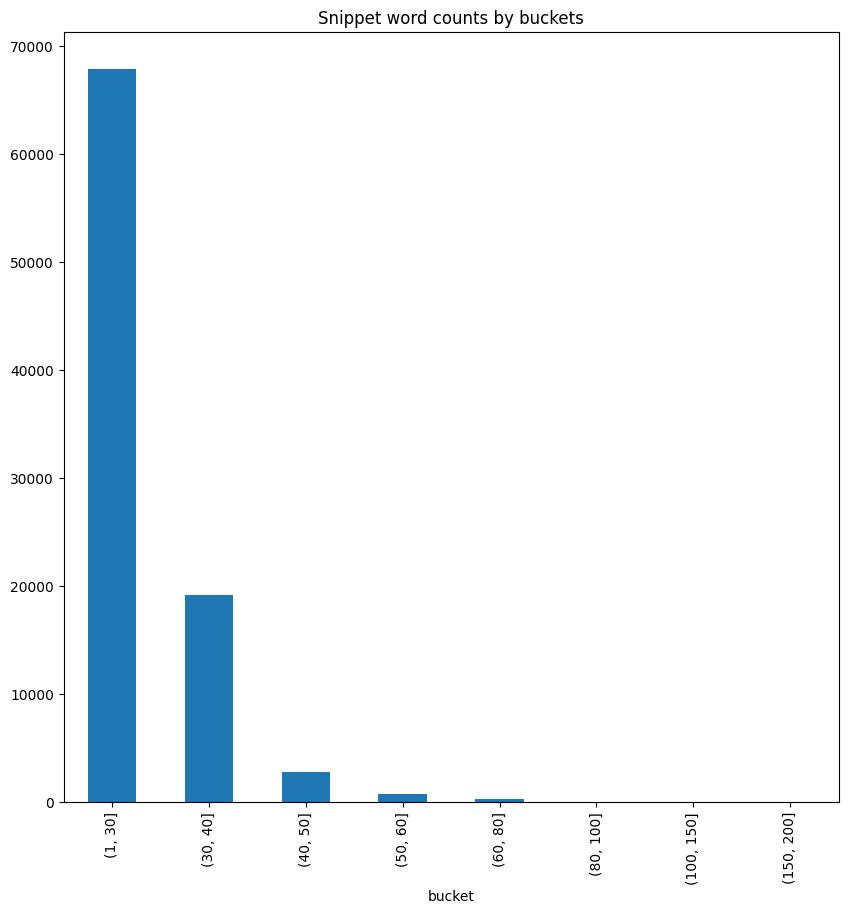

In [12]:
wcs_df = pd.DataFrame(data=wcs, columns=['snippet_wc'])
bins = np.array([1, 30, 40, 50, 60, 80, 100, 150, 200])
wcs_df["bucket"] = pd.cut(wcs_df.snippet_wc, bins)
values, bins = np.histogram(wcs, bins)
print(bins, "\n", values)
wcs_df1 = wcs_df.groupby(['bucket'])['bucket'].count()
wcs_df1.plot(kind='bar', figsize=(10,10), title='Snippet word counts by buckets')

More in detail, these are the counts for the buckets:
<table>
    <tr><th>Bin (from-to)</th><th>Count</th></tr>
    <tr><td>1-30</td><td>63677</td></tr>
    <tr><td>30-40</td><td>23638</td></tr>
    <tr><td>40-50</td><td>3590</td></tr>
    <tr><td>50-60</td><td>1011</td></tr>
    <tr><td>60-80</td><td>446</td></tr>
    <tr><td>80-100</td><td>62</td></tr>
    <tr><td>100-150</td><td>16</td></tr>
    <tr><td>150-200</td><td>0</td></tr>
</table>
<p>In sum, the outcome of snippet generation is not perfect, but a reasonable approximation. </p>

## Relevant Data for search
<p>Since the focus of this project is on search as an NLP task, the relevant data include the following fields in our Posts dataset:
   <ul><li>Body: this is the core data, segmented into optimally sized 'snippets'. </li>
       <li>Title: this can provide additional 'context' for the snippets, since snippets are short paragraphs, and may lack context.</li>
       <li>Tags: these can also be used for context in alternative (or addition) to Titles.</li>
       <li>ViewCount: not directly relevant, but can be helpful in designing a representatitve test set.</li>
   </ul></p>
<p>As we have found out, over 45% of the posts have empty Title or Tags. </p>
<p>In an actual development environment, we would want to implement a strategy to remedy the missing data. </p>
<p>Here are some options: 
    <ul>
       <li>Temporarily remove the 45% incomplete rows while experimenting with the 'good' rows to finalize a plan on how to search the corpus</li>
       <li>Once this is done, re-insert the incomplete data with a remedial strategy: 
       <ol><li>Treat Titles as regular snippets, and add the Tags to all snippets for context. 
              As a remedial strategy, train a Classifier to predict and add back, the missing Tags</li>
           <li>Use the Titles as context, adding them to all the snippets, and for remedial, use a Summarization model to predict the missing Titles</li>
       </ol></li>
    </ul></p>

<p>For this project, we will simply remove the incomplete rows, i.e., the rows with no Body, Title, or Tags.</p>
<p>We will prefix each snippet, including titles, with the text of the tags: this will not much alter the size of the snippets while providing some
context for the search engines.</p>

### Assembling a Search Corpus
<p>The complete StackExchange dataset consists of ~14K posts, yielding some 90K snippets. 55% of these have non-empty Title and Tags, as well as Body. There are 
6779 such row with incomplete text data. The remaining 7656 rows are our starting point dataset.</p>
<p>Processing over 50K text snippets generated from the complete rows -- depending on the computing resources on hand -- can be slow, and impractical in the 
present context, which is to explore some pros and cons of search as an NLP task, as well as to put together a simple development environment.</p>
<p>Going forwards, it is more convenient to further reduce the size of the search corpus, down to a more convenient 20K size, so as to speed up the indexing process. 
This will be our final corpus for this project. </p>
<p>To do so, we will select the posts with the most views, until we have reached the desired 20K snippets size, treating the titles as their own snippets. </p>

<p>The final data pipeline to create the "small" search corpus is as follows: 
<ol><li>Start with the 'original' StackExchange Health dataset, and convert the HTML of the Body column to text. This, as we saw, results in the 'posts.csv' file.</li>
    <li>Remove the posts that have empty Body, Title, and/or Tag columns. This gives us the 'posts_validated.csv' file, with complete data rows.</li>
    <li>From this, generate the snippets, and collect them in 'posts_snippets.csv'. </li>
    <li>Sort the posts by ViewCount, and draw from the 'posts_snippets.csv', adding the title as the first snippet of each post, till we reach the limit of 20k snippets. </li>
</ol></p>
<p>The resulting dataset for search is 'search_corpus.csv', which will be used as the input to the process of creating a search index with either Elasticsearch or the Semantic
Search Transformer model. As part of the pre-processing for each framework, we will prefix the tags to each snippet in the post. So we will be able to search over the snippets 
combined with their tags</p>

<p>The code for the above pipeline is in the 'prepare_data' function (and end-point) in main.py, and references functions in data.py. </p>